![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [114]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [118]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [9]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [120]:
# Código para complementar análisis descriptivo

# Análisis variable "season"
season_estadisticas = bikes.groupby('season')['total'].describe()
print("Estadísticas por temporada (season):")
print(season_estadisticas)

# Análisis variable "hour"
hour_estadisticas = bikes.groupby('hour')['total'].describe()
print("\nEstadísticas por hora del día (hour):")
print(hour_estadisticas)


Estadísticas por temporada (season):
         count        mean         std  min   25%    50%    75%    max
season                                                                
1       2686.0  116.343261  125.273974  1.0  24.0   78.0  164.0  801.0
2       2733.0  215.251372  192.007843  1.0  49.0  172.0  321.0  873.0
3       2733.0  234.417124  197.151001  1.0  68.0  195.0  347.0  977.0
4       2734.0  198.988296  177.622409  1.0  51.0  161.0  294.0  948.0

Estadísticas por hora del día (hour):
      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00  

**Análisis Punto 1**
1) Los resultados de la primera celda permiten validar claramente lo que intuitivamente se podría esperar,es decir, que en verano es cuando hay el mayor número de alquileres de bicicletas (promedio 234.4), seguido de la primavera (215.2) y otoño (198.9), versus invierno donde el número promedio de alquileres es muy bajo (116.3).
2)  Respecto a la hora, nuevamente se confirma lo que intuitivamente se esperaría: en las horas pico (7 a 9 am) hay el mayor número de alquileres con un máximo a las 8 am (promedio 362.8).
3)  Hay un número muy razonable de alquileres desde las 11 am que práctimente aumenta (o se mantiene) hasta llegar a la hora pico entre 5 y 6 pm (468.8 y 430.9), con un nivel razonable hasta las 8 pm.
4) Al final del día y en la madrugada (entre las 11 pm y las 6 am) el nivel de alquileres es muy bajo.
5) Tomando en cuenta la información estadística se puede determinar que la menor varianza está en invierno (125.3, lo cual a mi juicio tiene sentido), seguido por otoño (177.6), primavera (199) y verano con la mayor varianza (197.1).
6) Por su parte, la menor varianza están en las horas valle (10 pm a 6 am) y la mahyor varianza (me parece particular) está a las 8 am (231.7). A las 5 pm la varianza es menos alta (223.8).
7) En cuanto a los máximos números de alquileres se encuentran entre las 5 y 6 pm (970 y 977) y a las 8 am (839). Se debe mencionar que los máximos en la madrugada están muy por encima de la media, particularmente entre media noche y las 2 am (283, 168 y 119), lo cual podría identificarlos como "outliers", incluso al ver que hasta el 75% se mantienen relativamente bajos los números de alquileres en esas horas valle. 


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

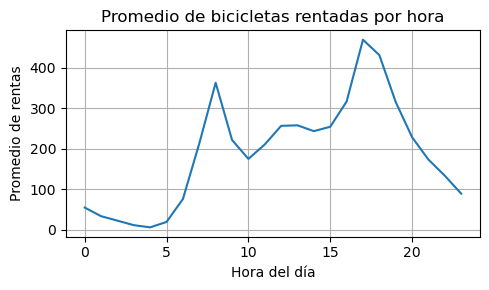

In [123]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"

# bikes.groupby('hour').total.mean().plot()
# La instrucción original NO imprimió (solamente imprimió "<Axes: xlabel='hour'>").
# Por lo tanto tuve que cambiar las instrucciones para imprimir

import matplotlib.pyplot as plt

# Crear una figura con tamaño específico
plt.figure(figsize=(5, 3))

# Graficar el promedio de alquileres por hora
bikes.groupby('hour').total.mean().plot()

# Añadir título y etiquetas
plt.title('Promedio de bicicletas rentadas por hora')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de rentas')
plt.grid(True)

# Asegurar que la gráfica se muestre
plt.tight_layout()
plt.show()


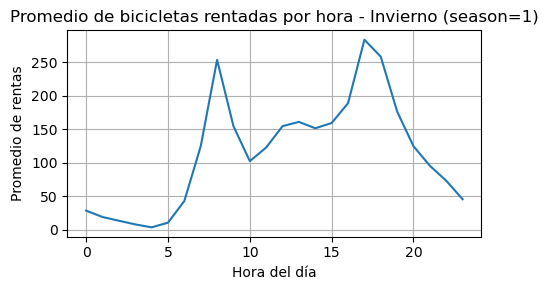

In [125]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

plt.figure(figsize=(5, 3))
bikes[bikes.season == 1].groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora - Invierno (season=1)')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de rentas')
plt.grid(True)
plt.tight_layout()
plt.show()

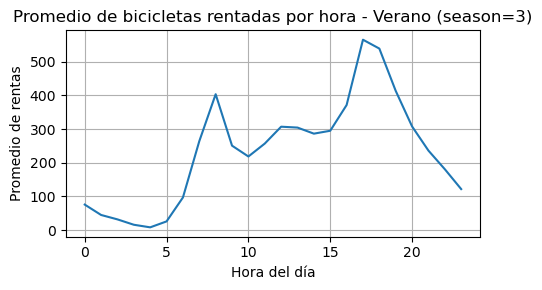

In [127]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
# Rentas promedio para cada valor de la variable "hour" en verano (season=3)

plt.figure(figsize=(5, 3))
bikes[bikes.season == 3].groupby('hour').total.mean().plot()
plt.title('Promedio de bicicletas rentadas por hora - Verano (season=3)')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de rentas')
plt.grid(True)
plt.tight_layout()
plt.show()


**Análisis Punto 2**
1) Lo primero que hay que destacar es que Las gráficas muestran un comportamiento idéntico en cuanto al comportamiento (subidas y bajadas) de alquileres según la hora del día, cambiando obviamente los niveles mayores o menores (como se vio en el punto 1) dependiendo de la estación.
2) Una característica importante destacar es que en invierno se ve una menor brecha entre los dos picos (8 am y 5 pm). En tal sentido, podría decir que, la primera gráfica de promedio de bicicletas alquiladas por hora permite ver el comportamiento similar a lo largo del día, pero no aporta suficiente información para el análisis, justamente por las diferencias en cada estación y, particularmente, entre invierno y verano.   

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [129]:
# Celda 3

# Se utiliza LinearRegression como modelo de regresión lineal para encontrar la relación lineal entre las variables predictoras (season y hour)
# y la variable objetivo "total" (número de alquileres de bicicletas).
from sklearn.linear_model import LinearRegression

# función para calcular el coeficiente de determinación (R²)
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np

# Dado que season es categporica (con valores de 1 a 4), creo dummies para esa variable
# De esta manera, el DataFrame va a contener 'hour' y las variables dummy 'season_2', 'season_3' y 'season_4' (variables predictoras)
X = pd.get_dummies(bikes[['season', 'hour']], columns=['season'], drop_first=True)

# Variable de respuesta
y = bikes['total']

# Se ajusta el modelo a los datos con X conteniendo las variables predictoras y y la variable de respuesta
model = LinearRegression()
model.fit(X, y)

# Se imprimen los coeficientes
print("Intercepto (Beta_0):", model.intercept_)
print("\nCoeficientes:")
for i, coeficientes in enumerate(model.coef_):
    feature_name = X.columns[i]
    print(f"{feature_name}: {coeficientes}")

# Se calcula el R² para evaluar el ajuste del modelo
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"\nR²: {r2:.4f}")

Intercepto (Beta_0): -6.430262462306189

Coeficientes:
hour: 10.545206094069913
season_2: 100.31723191606596
season_3: 119.46754994593167
season_4: 84.08311787296773

R²: 0.2234


**Interpretración resultados Punto 3**

1) El intercepto Beta_0 (número de bicicletas rentadas que se predicen cuando todas las variables predictoras son cero) tiene el valor de -6.43. Ese valor negativo se puede interpretar que en la temporada 1 a la hora 0 no habrían alquileres.
2) Coeficiente de hour = 10.55. Supone que hay linealidad y que por cada hora se aumenta el número de bicicletas en ese valor. Es decir, no tiene en cuenta la variación según hora pico o valle.
3) Coeficiente de season_2 = 100.31. Indica que, para una misma hora, en primavera se incrementa en 100 bicicletas respecto a invierno.
4) Coeficiente de season_3 = 119.47. Indica que, para una misma hora, en verano se incrementa en 119 bicicletas respecto a invierno.
5) Coeficiente de season_4 = 84.08. Indica que, para una misma hora, se incrementa en 84 bicicletas respecto a invierno.
6) R² = 0.2234. Este valor indica que este modelo de regresión lineal explica tan solo el 22.34% de la variablidad en la cantidad de bicicletas rentadas.

¿Cuáles son las limitaciones de la regresión lineal en este caso?
1) Es un modelo que no tiene en cuenta el comportamiento real (horas pico principalmente)
2) Explica solamente el 22% de la variabilidad (muy bajo)
3) El modelo no tiene en cuenta que pueden haber comportamientos diferentes en cada estación en las diferentes horas, estableciendo solamente diferencias de una estación a otra.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [131]:
# Celda 4
# Para el desarrollo de este punto seguí un proceso muy similar al del Laboratorio 1
# Voy a dividir el código en varias celdas según tenga sentido en la construcción manual del árbol (similar a como se hizo en el laboratorio 1).

# Definición de variables del problema
# Selección de variables predictoras
feature_cols = ['hour', 'season']
X = bikes[feature_cols]
y = bikes['total']

# Preparación para construir el árbol manual
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10  # Número de percentiles para evaluar puntos de corte
max_features = None
min_gain = 0.001  # Ganancia mínima para considerar una división

# Cálculo de posibles puntos de corte y ganancia para una variable

# Función para calcular MSE
def mse(y):
    if len(y) == 0:
        return 0
    return ((y - y.mean()) ** 2).mean()

# Función para calcular la reducción en MSE (ganancia)
def mse_reduction(X_col, y, split):
    # Filtrar observaciones según el punto de corte
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    # Tamaño de cada grupo
    n_l = len(y_l)
    n_r = len(y_r)
    
    if n_l == 0 or n_r == 0:
        return 0
    
    # MSE antes y después de la división
    mse_before = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    # Reducción ponderada en MSE
    mse_reduction = mse_before - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_reduction

# Ejemplo para la variable 'hour'
j = 0  # Índice de 'hour' en feature_cols
print(X.columns[j])

# Calcular posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
print("Posibles puntos de corte:", splits)

# Probar un punto de corte específico. Por ejemplo, el quinto punto de corte.
k = 5
reduction = mse_reduction(X.iloc[:, j], y, splits[k])
print(f"Reducción de MSE al dividir 'hour' en {splits[k]}: {reduction}")

hour
Posibles puntos de corte: [ 0.  2.  4.  7.  9. 12. 14. 16. 19. 21.]
Reducción de MSE al dividir 'hour' en 12.0: 5305.206789895026


In [133]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, reduction
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            reduction = mse_reduction(X.iloc[:, j], y, split)
                        
            if reduction > best_split[2]:
                best_split = [j, split, reduction]
    
    return best_split

# Obtención de la variable 'j', su punto de corte 'split' y su reducción de MSE
j, split, reduction = best_split(X, y, 5)
print(f"Variable óptima: {X.columns[j]}")
print(f"Punto de corte: {split}")
print(f"Reducción de MSE: {reduction}")

Variable óptima: hour
Punto de corte: 8.0
Reducción de MSE: 9134.40591176651


In [135]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split
X_l = X.loc[filter_l]
X_r = X.loc[~filter_l]
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

# Verificar tamaños de los subconjuntos
print(f"Total de observaciones: {y.shape[0]}")
print(f"Observaciones con hour < 8: {y_l.shape[0]}")
print(f"Observaciones con hour >= 8: {y_r.shape[0]}")

# Comparar las medias de alquileres en cada grupo
print(f"\nMedia total de alquileres: {y.mean():.2f}")
print(f"Media de alquileres cuando hour < 8: {y_l.mean():.2f}")
print(f"Media de alquileres cuando hour >= 8: {y_r.mean():.2f}")

Total de observaciones: 10886
Observaciones con hour < 8: 3594
Observaciones con hour >= 8: 7292

Media total de alquileres: 191.57
Media de alquileres cuando hour < 8: 55.44
Media de alquileres cuando hour >= 8: 258.67


In [137]:
# Crecimiento recursivo del árbol

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_samples=5):
    
    # Si hay muy pocas observaciones
    if X.shape[0] <= min_samples:
        tree = dict(y_pred=y.mean(), level=level, split=-1, n_samples=X.shape[0], gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, reduction = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()  # En regresión, la predicción es el valor medio
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=reduction)
    
    # Revisar el criterio de parada 
    if reduction < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
    # Verificar que ambas particiones tengan suficientes observaciones
    if X_l.shape[0] < min_samples or X_r.shape[0] < min_samples:
        return tree
    
    tree['split'] = [j, split, X.columns[j]]  # Guardamos también el nombre de la variable
    
    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples=min_samples)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, min_samples=min_samples)
    
    return tree

In [139]:
# Aplicación de la función tree_grow
# Crear un árbol con profundidad limitada para asegurar al menos 6 nodos finales
tree = tree_grow(X, y, min_gain=1.0, max_depth=3, num_pct=5)

# Mostrar el árbol (estructura completa)
tree

{'y_pred': 191.57413191254824,
 'level': 0,
 'split': [0, 8.0, 'hour'],
 'n_samples': 10886,
 'gain': 9134.40591176651,
 'sl': {'y_pred': 55.437673900946024,
  'level': 1,
  'split': [0, 6.0, 'hour'],
  'n_samples': 3594,
  'gain': 2700.70810914734,
  'sl': {'y_pred': 25.177719821162444,
   'level': 2,
   'split': [0, 2.0, 'hour'],
   'n_samples': 2684,
   'gain': 191.40441543023144,
   'sl': {'y_pred': 44.51045104510451,
    'level': 3,
    'split': -1,
    'n_samples': 909,
    'gain': 145.70023409125633},
   'sr': {'y_pred': 15.27718309859155,
    'level': 3,
    'split': -1,
    'n_samples': 1775,
    'gain': 19.614949636834638}},
  'sr': {'y_pred': 144.68791208791208,
   'level': 2,
   'split': [0, 6.5, 'hour'],
   'n_samples': 910,
   'gain': 4682.4693877551,
   'sl': {'y_pred': 76.25934065934067,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 371.54779616750875},
   'sr': {'y_pred': 213.11648351648353,
    'level': 3,
    'split': -1,
    'n_samples': 455,
  

Desempeño del árbol de decisión manual:
Error cuadrático medio (MSE): 17454.35
Raíz del error cuadrático medio (RMSE): 132.11
Coeficiente de determinación (R²): 0.4680


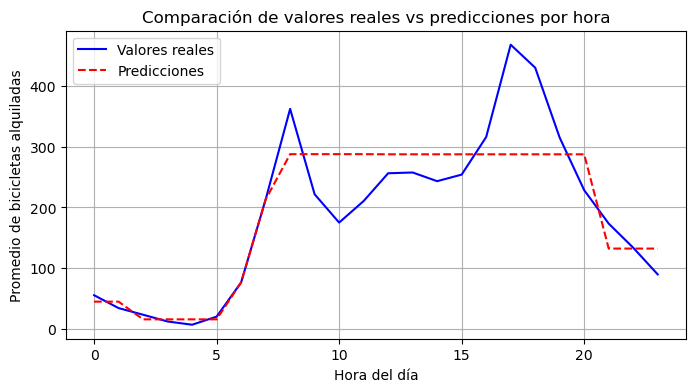

In [141]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        j, split, _ = tree['split']  # Extraemos el índice y valor de corte
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacío solo continúa con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  # Si el nodo derecho está vacío solo continúa con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
    
    return predicted

# Realizar predicciones con el árbol manual
y_pred = tree_predict(X, tree)

# Evaluar el desempeño del árbol
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"Desempeño del árbol de decisión manual:")
print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

# Visualizar predicciones por hora
hour_avg_real = bikes.groupby('hour')['total'].mean()
hour_avg_pred = pd.DataFrame({'hour': bikes['hour'], 'pred': y_pred}).groupby('hour').mean()

plt.figure(figsize=(8, 4))
plt.plot(hour_avg_real.index, hour_avg_real.values, 'b-', label='Valores reales')
plt.plot(hour_avg_pred.index, hour_avg_pred['pred'].values, 'r--', label='Predicciones')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Comparación de valores reales vs predicciones por hora')
plt.legend()
plt.grid(True)
plt.show()

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

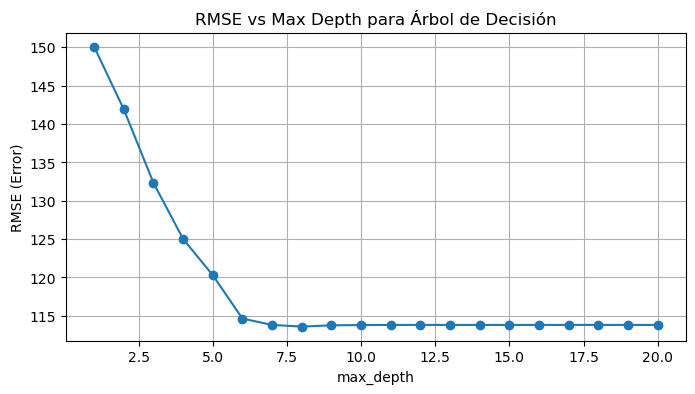

In [143]:
# Celda 5

# Importar las bibliotecas necesarias
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rmse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la librería sklearn
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Usar validación cruzada para evaluar el modelo
    mse_scores = -cross_val_score(tree, X_train, y_train, cv=5, 
                                 scoring='neg_mean_squared_error')
    
    # Calcular RMSE a partir de MSE
    rmse = np.sqrt(mse_scores.mean())
    rmse_scores.append(rmse)

# Gráfica max_depth versus RMSE (error del modelo)
plt.figure(figsize=(8, 4))
plt.plot(max_depth_range, rmse_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('RMSE (Error)')
plt.title('RMSE vs Max Depth para Árbol de Decisión')
plt.grid(True)
plt.show()

In [145]:
# Encontrar la mejor profundidad (con menor RMSE)
best_depth = max_depth_range[np.argmin(rmse_scores)]
min_rmse = min(rmse_scores)

# Mostrar el mejor resultado
print(f"Mejor profundidad (max_depth): {best_depth}")
print(f"RMSE mínimo: {min_rmse:.2f}")


Mejor profundidad (max_depth): 8
RMSE mínimo: 113.60


In [151]:
# Entrenar el modelo final con la mejor profundidad
best_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)

# Evaluar el modelo en conjuntos de entrenamiento y prueba
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Calcular métricas de desempeño
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calcular R² para comparar con el modelo de regresión lineal del punto 3
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nDesempeño del modelo:")
print(f"RMSE en entrenamiento: {train_rmse:.2f}")
print(f"RMSE en prueba: {test_rmse:.2f}")
print(f"R² en entrenamiento: {train_r2:.4f}")
print(f"R² en prueba: {test_r2:.4f}")

# Comparar con el modelo de regresión lineal del punto 3
print("\nComparación con el modelo de regresión lineal del punto 3:")
print(f"R² de regresión lineal: 0.2234")
print(f"R² de árbol de decisión: {test_r2:.4f}")


Desempeño del modelo:
RMSE en entrenamiento: 112.51
RMSE en prueba: 116.04
R² en entrenamiento: 0.6136
R² en prueba: 0.5921

Comparación con el modelo de regresión lineal del punto 3:
R² de regresión lineal: 0.2234
R² de árbol de decisión: 0.5921


**Análisis del desempeño del modelo**
Para el análisis del desempeño estoy utilizando dos métricas: RMSE y R².
1) Lo primero es que el RMSE de entrenamiento es similar al de prueba, por lo cual se puede asumir que no hay un sobreajuste significativo.
2) EL RMSE de 116.04, a pesar de que la media de alquileres diario es de 191, este error es de alrededor de un 61%, lo cual es alto. Sin embargo, teniendo en cuenta que hay horas en que el número de bicicletas alquiladas está por encima de 400, ese RMSE suena razonable.
3) Lo segundo es que en este caso el coeficiente de determinación (0.5921) significa que el árbol de decisión explica alrededor del 59% de la variabilidad en el número de bicicletas alquiladas.
4) Respecto al modelo de regresión (punto 3), ese modelo tenía un R² de 0.2234, es decir, solo explicaba el 22% de la variabilidad, mucho menor que la lograda con el árbol de decisión.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [153]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [155]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [157]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [159]:
# Celda 6

# Punto 6 - Árbol de decisión y regresión logística

# Importar los modelos necesarios
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Definición de los 2 modelos: árbol de decisión y regresión logística
models = {
    'dt': DecisionTreeClassifier(random_state=42),
    'lr': LogisticRegression(max_iter=1000, random_state=42)
}

# Separación de variables predictoras (X) y variable de interés (y) ya está hecha:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

y_pred


,dt,lr
1483,0,1
2185,0,1
2520,1,1
3721,0,1
3727,0,0
...,...,...
3077,1,0
5166,1,0
2227,1,1
5684,0,0


In [161]:
# Evaluación del desempeño de cada modelo
from sklearn.metrics import accuracy_score, f1_score

for model in models.keys():
    # Calcular accuracy (proporción de predicciones correctas)
    acc = accuracy_score(y_test, y_pred[model])
    
    # Calcular F1-score
    f1 = f1_score(y_test, y_pred[model])
    
    print(f"Modelo: {model}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("---------------------")

Modelo: dt
Accuracy: 0.5407
F1-Score: 0.5410
---------------------
Modelo: lr
Accuracy: 0.6147
F1-Score: 0.6025
---------------------


**Resultados parciales**
La evaluación del desempeño de ambos modelos (aún sin calibrar al árbol con un parámetro) es favorable al modelo de regresión logística, tanto en Accuracy (0.6147 VS 0.5407), como en F1-Score (0.6025 VS 0.5410).

In [163]:
# Ahora se va a implementar la calibración del modelo con el parámetro max_depth
# Calibración del parámetro max_depth para el árbol de decisión
from sklearn.model_selection import GridSearchCV

# Se define el rango de valores para max_depth para determinar cuál de ellos es el óptimo
param_grid = {'max_depth': [3, 5, 7, 10, 15, 20, None]}

# Se crea el objeto GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),  # Mismo modelo con semilla fija
    param_grid,                              # Valores a probar
    cv=5,                                    # Validación cruzada con 5 folds
    scoring='f1',                            # Optimizando para F1-Score
    n_jobs=-1                                # Usar todos los núcleos disponibles
)

# Ejecutar la búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Mostrar los resultados
print("Resultados de la calibración del árbol de decisión:")
print(f"Mejor valor de max_depth: {grid_search.best_params_['max_depth']}")
print(f"Mejor F1-Score en validación: {grid_search.best_score_:.4f}")

# Actualizar el modelo con los mejores parámetros
best_tree = grid_search.best_estimator_
models['dt'] = best_tree

# Actualizar las predicciones con el modelo mejorado
y_pred['dt'] = best_tree.predict(X_test)

# Evaluar el modelo mejorado
acc_improved = accuracy_score(y_test, y_pred['dt'])
f1_improved = f1_score(y_test, y_pred['dt'])

print("\nDesempeño del árbol mejorado:")
print(f"Accuracy: {acc_improved:.4f}")
print(f"F1-Score: {f1_improved:.4f}")
print(f"Mejora en Accuracy: {(acc_improved - 0.5407) * 100:.2f}%")
print(f"Mejora en F1-Score: {(f1_improved - 0.5410) * 100:.2f}%")

Resultados de la calibración del árbol de decisión:
Mejor valor de max_depth: 5
Mejor F1-Score en validación: 0.6078

Desempeño del árbol mejorado:
Accuracy: 0.6400
F1-Score: 0.6633
Mejora en Accuracy: 9.93%
Mejora en F1-Score: 12.23%


**Evaluación desempeño**
La evaluación del desempeño de ambos modelos después de calibrar el árbol con el parámetro max_depth mejora notablemente el modelo del árbol, tanto en Accuracy, como en F1-Score. De esta manera, el desempeño del árbol termina siendo mejor que el de regresión logística:

Árbol  
Accuracy:  0.6400  
F1-Score   0.6633           

Regresión Logística  
Accuracy:  0.6147  
F1-Socre:  0.6025


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [167]:
# Celda 7

# Punto 7 - Votación Mayoritaria

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Se define el número total de estimadores y tamaño de cada grupo
n_total = 300
n_per_group = 100
np.random.seed(123)

# Obtener tamaño de la muestra de entrenamiento
n_samples = X_train.shape[0]

# Crear 300 muestras bootstrap
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_total)]

# Crear semillas aleatorias para reproducibilidad
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_total)

# Inicializar diccionario para almacenar los modelos
models = {}

# Primer grupo: 100 árboles de decisión con max_depth específico
max_depth_value = 5  # Utilizo el valor óptimo encontrado en el punto 6
for i in range(0, n_per_group): # Desde 0 hasta 99
    models[i] = DecisionTreeClassifier(max_depth=max_depth_value, random_state=seeds[i])
    models[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Segundo grupo: 100 árboles de decisión con min_samples_leaf específico
min_samples_leaf_value = 10  # Un valor razonable para este parámetro
for i in range(n_per_group, 2*n_per_group): # Desde 100 hasta 199
    models[i] = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf_value, random_state=seeds[i])
    models[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Tercer grupo: 100 modelos de regresión logística
for i in range(2*n_per_group, 3*n_per_group): # (desde 200 hasta 299)
    models[i] = LogisticRegression(max_iter=1000, random_state=seeds[i])
    # No usamos C=1.0/regularization para mantener la simplicidad
    models[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Realizar predicciones con todos los modelos
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_total)))
for i in range(n_total):
    y_pred_df.iloc[:, i] = models[i].predict(X_test)

# Evaluar cada grupo por separado
# Grupo 1: Árboles con max_depth específico
y_pred_group1 = (y_pred_df.iloc[:, 0:n_per_group].sum(axis=1) >= (n_per_group / 2)).astype(np.int64)
accuracy_group1 = metrics.accuracy_score(y_test, y_pred_group1)
f1_group1 = metrics.f1_score(y_test, y_pred_group1)

# Grupo 2: Árboles con min_samples_leaf específico
y_pred_group2 = (y_pred_df.iloc[:, n_per_group:2*n_per_group].sum(axis=1) >= (n_per_group / 2)).astype(np.int64)
accuracy_group2 = metrics.accuracy_score(y_test, y_pred_group2)
f1_group2 = metrics.f1_score(y_test, y_pred_group2)

# Grupo 3: Regresiones logísticas
y_pred_group3 = (y_pred_df.iloc[:, 2*n_per_group:3*n_per_group].sum(axis=1) >= (n_per_group / 2)).astype(np.int64)
accuracy_group3 = metrics.accuracy_score(y_test, y_pred_group3)
f1_group3 = metrics.f1_score(y_test, y_pred_group3)

# Ensamble completo: Votación mayoritaria de todos los modelos
y_pred_ensamble = (y_pred_df.sum(axis=1) >= (n_total / 2)).astype(np.int64)
accuracy_ensamble = metrics.accuracy_score(y_test, y_pred_ensamble)
f1_ensamble = metrics.f1_score(y_test, y_pred_ensamble)

# Imprimir resultados
print("Resultados por grupo:")
print("---------------------")
print(f"Grupo 1 (Árboles con max_depth={max_depth_value}):")
print(f"Accuracy: {accuracy_group1:.4f}")
print(f"F1-Score: {f1_group1:.4f}")
print("\n")
print(f"Grupo 2 (Árboles con min_samples_leaf={min_samples_leaf_value}):")
print(f"Accuracy: {accuracy_group2:.4f}")
print(f"F1-Score: {f1_group2:.4f}")
print("\n")
print(f"Grupo 3 (Regresiones logísticas):")
print(f"Accuracy: {accuracy_group3:.4f}")
print(f"F1-Score: {f1_group3:.4f}")
print("\n")
print("Ensamble completo:")
print(f"Accuracy: {accuracy_ensamble:.4f}")
print(f"F1-Score: {f1_ensamble:.4f}")

Resultados por grupo:
---------------------
Grupo 1 (Árboles con max_depth=5):
Accuracy: 0.6553
F1-Score: 0.6528


Grupo 2 (Árboles con min_samples_leaf=10):
Accuracy: 0.6560
F1-Score: 0.6551


Grupo 3 (Regresiones logísticas):
Accuracy: 0.6153
F1-Score: 0.6023


Ensamble completo:
Accuracy: 0.6353
F1-Score: 0.6256


**Evaluación desempeño**
1) Los resultados Accuracy y F1-Score de los grupos 1 y 2 (árboles con parámetros max_depth=5 y min_samples_leaf_value=10 respectivamente) son prácticamente iguales, mientras que los resultados del grupo 3 (muestras de regresiones logísticas) están por debajo.
2) Aunque se esperaría que el resultado del ensamble con metodología de votación mayoritaria fuera mejor que los tres modelos, los resultados están por debajo de los modelos del grupo 1 y grupo 2, aunque mejor que el modelo del grupo 3. 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [169]:
# Celda 8

# Se utilizan los mismos modelos y muestras del punto 7
# Se calculan los pesos basados en precisión OOB para cada modelo

# Arrays para almacenar pesos y predicciones
weights = np.zeros(n_total)
y_pred_all = np.zeros((X_test.shape[0], n_total))

# Calcular precisión OOB y recopilar predicciones
for i in range(n_total):
    # Obtener índices out-of-bag
    oob_indices = np.array([j for j in range(n_samples) if j not in samples[i]])
    
    if len(oob_indices) > 0:  # Si hay muestras OOB
        # Hacer predicciones en muestras OOB
        oob_pred = models[i].predict(X_train.iloc[oob_indices])
        # Calcular precisión OOB
        weights[i] = metrics.accuracy_score(y_train.iloc[oob_indices], oob_pred)
    else:
        weights[i] = 0.5  # Valor por defecto si no hay muestras OOB
    
    # Guardar predicciones para test
    y_pred_all[:, i] = models[i].predict(X_test)

# Convertir precisiones a pesos
alpha = weights / weights.sum()

# Ensamble completo con votación ponderada
y_pred_weighted = (np.sum(y_pred_all * alpha, axis=1) >= 0.5).astype(np.int64)
accuracy_weighted = metrics.accuracy_score(y_test, y_pred_weighted)
f1_weighted = metrics.f1_score(y_test, y_pred_weighted)

# Evaluación de grupos individuales con votación ponderada
# Grupo 1: Árboles con max_depth específico
alpha_group1 = weights[0:n_per_group] / weights[0:n_per_group].sum()
y_pred_weighted_g1 = (np.sum(y_pred_all[:, 0:n_per_group] * alpha_group1, axis=1) >= 0.5).astype(np.int64)
accuracy_g1 = metrics.accuracy_score(y_test, y_pred_weighted_g1)
f1_g1 = metrics.f1_score(y_test, y_pred_weighted_g1)

# Grupo 2: Árboles con min_samples_leaf específico
alpha_group2 = weights[n_per_group:2*n_per_group] / weights[n_per_group:2*n_per_group].sum()
y_pred_weighted_g2 = (np.sum(y_pred_all[:, n_per_group:2*n_per_group] * alpha_group2, axis=1) >= 0.5).astype(np.int64)
accuracy_g2 = metrics.accuracy_score(y_test, y_pred_weighted_g2)
f1_g2 = metrics.f1_score(y_test, y_pred_weighted_g2)

# Grupo 3: Regresiones logísticas
alpha_group3 = weights[2*n_per_group:3*n_per_group] / weights[2*n_per_group:3*n_per_group].sum()
y_pred_weighted_g3 = (np.sum(y_pred_all[:, 2*n_per_group:3*n_per_group] * alpha_group3, axis=1) >= 0.5).astype(np.int64)
accuracy_g3 = metrics.accuracy_score(y_test, y_pred_weighted_g3)
f1_g3 = metrics.f1_score(y_test, y_pred_weighted_g3)

# Imprimir resultados
print("Resultados de votación ponderada:")
print("--------------------------------")
print(f"Grupo 1 (Árboles con max_depth=5):")
print(f"Accuracy: {accuracy_g1:.4f}")
print(f"F1-Score: {f1_g1:.4f}")
print("\n")
print(f"Grupo 2 (Árboles con min_samples_leaf=10):")
print(f"Accuracy: {accuracy_g2:.4f}")
print(f"F1-Score: {f1_g2:.4f}")
print("\n")
print(f"Grupo 3 (Regresiones logísticas):")
print(f"Accuracy: {accuracy_g3:.4f}")
print(f"F1-Score: {f1_g3:.4f}")
print("\n")
print("Ensamble ponderado completo:")
print(f"Accuracy: {accuracy_weighted:.4f}")
print(f"F1-Score: {f1_weighted:.4f}")

Resultados de votación ponderada:
--------------------------------
Grupo 1 (Árboles con max_depth=5):
Accuracy: 0.6547
F1-Score: 0.6514


Grupo 2 (Árboles con min_samples_leaf=10):
Accuracy: 0.6533
F1-Score: 0.6505


Grupo 3 (Regresiones logísticas):
Accuracy: 0.6160
F1-Score: 0.6028


Ensamble ponderado completo:
Accuracy: 0.6340
F1-Score: 0.6242


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Celda 9

Resultados por grupo:
---------------------

Votación Mayoritaria ------------------------ Votación Ponderada

Grupo 1 (Árboles con max_depth=5)  
Accuracy: 0.6553 ---------------------------- 0.6547  
F1-Score: 0.6528 ---------------------------- 0.6514

Grupo 2 (Árboles con min_samples_leaf=10)  
Accuracy: 0.6560 ---------------------------- 0.6533  
F1-Score: 0.6551 ---------------------------- 0.6505

Grupo 3 (Regresiones logísticas)  
Accuracy: 0.6153 ---------------------------- 0.6160  
F1-Score: 0.6023 ---------------------------- 0.6028

Ensamble completo:  
Accuracy: 0.6353 ---------------------------- 0.6340  
F1-Score: 0.6256 ---------------------------- 0.6242

**Análisis**

1) Los árboles de decisión en ambos casos tienen un rendimiento superior significativo respecto a las regresiones logísticas, tanto por votación mayoritaria como por votación ponderada.
2) El grupo con mejor desempeño en votación mayoritaria fue el de árboles con min_samples_leaf=10, más allá de que el de árboles con max_depth=5 tuviera un desempeño muy cercano.
3) En votación ponderada, el mejor grupo fue el de árboles con max_depth=5
4) Contrario a lo esperado, con ambas metodologías el desempeño del ensamble completo estuvo por debajo de los modelos de los árboles y, a su vez, en mabos casos los resultados del modelo de ensamble obtuvieron desempeños  similares.
   Ventajas y desventajas
6) Votación mayoritaria: tiene mayor simplicidad en la implementación, pero no toma en cuenta las precisiones de los modelos en el momento de la votación y por lo tanto si la mayoría de los modelos son débiles van a superar en votos a los modelos fuertes. A pesar de ello, reitero, resultó con mejor desempeño que votación ponderada.
7) Votación ponderada: otorga mayor peso a los modelos con mejor desempeño, y los pesos pueden calcularse usando diferentes métricas según el objetivo (precisión, F1-score, etc), lo cual le da flexibilidad. Una desventaja en este caso específico parece ser que La inclusión de modelos de menor desempeño, como regresiones logísticas, tiende a disminuir la eficacia del ensamble completo.
